## Predicting the Sales per Merchant per day for the next 3 months

## Overview

In this project I will be using Facebook Prophet because it gives a more overview in few lines of code. 

Facebook Prophet: Prophet is a forecasting library developed by Facebook. It combines time series decomposition, trend modeling, and seasonality estimation to provide accurate forecasts. Prophet also handles missing data and outliers effectively. Facebook prophet is effective because it shows trends, weekly, daily, month, yearly trends all at once. 

In [1]:
# install dependencies
#pip install fbprophet

In [2]:
# import dependencies
import numpy as np
import pandas as pd
from prophet import Prophet

#### Reading in the csv file into a dataframe

In [13]:
df= pd.read_csv('Salt_transactions.csv', low_memory=False)
df.head()

,merchant_id,terminal_id,transaction_create_date,transaction_id,transaction_total_amount,merchant_registration_date,has_loyalty,transaction_currency,transaction_tip_amount,transaction_account_type
0,17,5589368,20/01/2021,25707962,9060.0,13/08/2020,NaN,ISK,0.0,Debit
1,17,5589368,22/09/2020,2857362,4500.0,13/08/2020,NaN,ISK,0.0,NaN
2,17,5589368,10/05/2021,51950962,6370.0,13/08/2020,NaN,ISK,0.0,Debit
3,17,5589368,10/05/2021,51999387,11330.0,13/08/2020,NaN,ISK,0.0,Debit
4,17,5589368,10/05/2021,52037737,1500.0,13/08/2020,NaN,ISK,0.0,Debit


In [14]:
#checking for the dataframe's information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262771 entries, 0 to 262770
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   merchant_id                 262771 non-null  int64  
 1   terminal_id                 262771 non-null  int64  
 2   transaction_create_date     262771 non-null  object 
 3   transaction_id              262771 non-null  int64  
 4   transaction_total_amount    262771 non-null  float64
 5   merchant_registration_date  262771 non-null  object 
 6   has_loyalty                 90549 non-null   object 
 7   transaction_currency        262771 non-null  object 
 8   transaction_tip_amount      262606 non-null  float64
 9   transaction_account_type    224541 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 20.0+ MB


# **Data Cleaning and Preprocessing**

The columns we need for predicting are date and sales. 
if predicting for a product or number of products we would introduce filter on the dataframe to predict for the product first, drop the columns which are not necessary for this project

In [15]:
# Dropping the unwanted columns
columns= ['terminal_id', 'transaction_id', 'merchant_registration_date', 'has_loyalty', 'transaction_currency','transaction_tip_amount', 'transaction_account_type']
df.drop(columns, axis=1, inplace=True)

In [16]:
df.head()

,merchant_id,transaction_create_date,transaction_total_amount
0,17,20/01/2021,9060.0
1,17,22/09/2020,4500.0
2,17,10/05/2021,6370.0
3,17,10/05/2021,11330.0
4,17,10/05/2021,1500.0


In [17]:
# checking for null values 
df.isnull().sum()

merchant_id                 0
transaction_create_date     0
transaction_total_amount    0
dtype: int64

In [18]:
# Checking the datatype of columns
df.dtypes

merchant_id                   int64
transaction_create_date      object
transaction_total_amount    float64
dtype: object

In [21]:
# Changing the date column to datetime from object
df['transaction_create_date']= pd.to_datetime(df['transaction_create_date'], infer_datetime_format=True)

In [83]:
# Confirming the changed data type
df.dtypes

merchant_id                          int64
transaction_create_date     datetime64[ns]
transaction_total_amount           float64
dtype: object

In [26]:
df.head()

,merchant_id,transaction_create_date,transaction_total_amount
0,17,2021-01-20,9060.0
1,17,2020-09-22,4500.0
2,17,2021-10-05,6370.0
3,17,2021-10-05,11330.0
4,17,2021-10-05,1500.0


##### It can be observed that the date column is not sorted, so I will sort it in a chronological order to have an idea of the first and last date of transaction 

In [80]:
# Sorting the dataframe by the transaction_create_date column
df.sort_values(by=['transaction_create_date'], ignore_index=True, inplace=True )
df

,merchant_id,transaction_create_date,transaction_total_amount
0,10,2020-01-09,2700.0
1,10,2020-01-09,3700.0
2,10,2020-01-09,25000.0
3,10,2020-01-09,1600.0
4,56,2020-01-09,12480.0
...,...,...,...
262766,719,2021-12-06,3950.0
262767,100,2021-12-06,850.0
262768,100,2021-12-06,900.0
262769,719,2021-12-06,990.0


In [95]:
# Checking for the merchant with id 10
df[df['merchant_id'] == 10]

,merchant_id,transaction_create_date,transaction_total_amount
0,10,2020-01-09,2700.0
1,10,2020-01-09,3700.0
2,10,2020-01-09,25000.0
3,10,2020-01-09,1600.0
22,10,2020-01-09,19000.0
...,...,...,...
262634,10,2021-12-06,5450.0
262657,10,2021-12-06,4300.0
262664,10,2021-12-06,6550.0
262684,10,2021-12-06,900.0


##### Now we can see the first and last  date of transaction can be seen for the merchant_id 10 in the above subset of the dataframe

In [84]:
# Checking for the unique merchantsin the dataframe
df['merchant_id'].unique()

array([  10,   56,   75,   80,  103,   17,    2,   11,  719,   33,  165,
         20,   14,  456,  100,    9,  188,   12, 1006], dtype=int64)

### Creating a filtered table for the merchant with id 10 only

In [90]:
# Creating a copy of a subset of the dataframe to include only merchant id 10

frame = df[df['merchant_id'] == 10].copy()

In [181]:
frame.describe()

,y
count,15749.000000
mean,1408.760874
std,1365.035654
min,1.000000
25%,895.000000
50%,995.000000
75%,1790.000000
max,125275.000000


In [91]:
# Checking out the filtered dataframe
frame

,merchant_id,transaction_create_date,transaction_total_amount
0,10,2020-01-09,2700.0
1,10,2020-01-09,3700.0
2,10,2020-01-09,25000.0
3,10,2020-01-09,1600.0
22,10,2020-01-09,19000.0
...,...,...,...
262634,10,2021-12-06,5450.0
262657,10,2021-12-06,4300.0
262664,10,2021-12-06,6550.0
262684,10,2021-12-06,900.0


### The input to prophet is always a dataframe that thta has two columns `ds`  representing the date column and `y` representing the value we want to forecast

#### So the filtered `merchant_id` column will be dropped

In [96]:
# Dropping the merchant_id column
frame.drop('merchant_id', axis=1, inplace=True)
frame.head()

,transaction_create_date,transaction_total_amount
0,2020-01-09,2700.0
1,2020-01-09,3700.0
2,2020-01-09,25000.0
3,2020-01-09,1600.0
22,2020-01-09,19000.0


In [97]:
# Changing the column names to ds and y

frame.columns = ['ds', 'y']
frame.head()

,ds,y
0,2020-01-09,2700.0
1,2020-01-09,3700.0
2,2020-01-09,25000.0
3,2020-01-09,1600.0
22,2020-01-09,19000.0


In [98]:
frame.tail()

,ds,y
262634,2021-12-06,5450.0
262657,2021-12-06,4300.0
262664,2021-12-06,6550.0
262684,2021-12-06,900.0
262749,2021-12-06,1000.0


### Creating a Time Series Model

In [99]:
# Creating an instance of the Prophet package
m = Prophet(interval_width = 0.95)

In [100]:
# Trianing the model
training_m = m.fit(frame)

17:19:47 - cmdstanpy - INFO - Chain [1] start processing
17:19:49 - cmdstanpy - INFO - Chain [1] done processing


### Evaluating the model

In [101]:
# Creating a future dataframe up to 3 months
future  = m.make_future_dataframe(periods = 90, freq = 'D')

In [103]:
# Verifying if the future data has been added to the historic data
future.tail()

,ds
244,2022-03-02
245,2022-03-03
246,2022-03-04
247,2022-03-05
248,2022-03-06


### Forecasting the sales values using the future dataframe

In [123]:
forecast = m.predict(future)

In [124]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-09,55785.385796,-2.021563e+06,2.002929e+06,55785.385796,55785.385796,-4267.302501,-4267.302501,-4267.302501,-4267.302501,-4267.302501,-4267.302501,0.0,0.0,0.0,51518.083295
1,2020-01-10,62095.232696,-1.991032e+06,2.094006e+06,62095.232696,62095.232696,-8062.577245,-8062.577245,-8062.577245,-8062.577245,-8062.577245,-8062.577245,0.0,0.0,0.0,54032.655451
2,2020-02-09,251390.639703,-1.795582e+06,2.207696e+06,251390.639703,251390.639703,39992.340266,39992.340266,39992.340266,39992.340266,39992.340266,39992.340266,0.0,0.0,0.0,291382.979969
3,2020-02-10,257700.486603,-1.839079e+06,2.309906e+06,257700.486603,257700.486603,779.551479,779.551479,779.551479,779.551479,779.551479,779.551479,0.0,0.0,0.0,258480.038082
4,2020-03-09,134637.529403,-1.835203e+06,1.943846e+06,134637.529403,134637.529403,779.551479,779.551479,779.551479,779.551479,779.551479,779.551479,0.0,0.0,0.0,135417.080882


In [120]:
# Checking the forecasted values
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
244,2022-03-02,2129.588891,-2.132714e+06,2.090914e+06,-212927.868984,211310.275103,-6474.793542,-6474.793542,-6474.793542,-6474.793542,-6474.793542,-6474.793542,0.0,0.0,0.0,-4345.204651
245,2022-03-03,2129.963726,-2.048347e+06,2.147765e+06,-216665.794841,213899.672770,-4267.302501,-4267.302501,-4267.302501,-4267.302501,-4267.302501,-4267.302501,0.0,0.0,0.0,-2137.338775
246,2022-03-04,2130.338561,-2.081073e+06,2.034956e+06,-219691.562541,216139.650565,-8062.577245,-8062.577245,-8062.577245,-8062.577245,-8062.577245,-8062.577245,0.0,0.0,0.0,-5932.238684
247,2022-03-05,2130.713395,-1.907907e+06,2.139019e+06,-222682.988515,220230.232269,-6948.832927,-6948.832927,-6948.832927,-6948.832927,-6948.832927,-6948.832927,0.0,0.0,0.0,-4818.119531
248,2022-03-06,2131.088230,-1.939764e+06,2.137258e+06,-227157.655147,223848.919088,39992.340266,39992.340266,39992.340266,39992.340266,39992.340266,39992.340266,0.0,0.0,0.0,42123.428496


In [114]:
forecast

,ds,yhat
159,2021-12-07,-12920.657577
160,2021-12-08,-4376.690754
161,2021-12-09,-2168.824879
162,2021-12-10,-5963.724788
163,2021-12-11,-4849.605635
...,...,...
244,2022-03-02,-4345.204651
245,2022-03-03,-2137.338775
246,2022-03-04,-5932.238684
247,2022-03-05,-4818.119531


### Replicating the process for all the merchants

In [144]:
# checking the unique ids of merchants
merchants= df['merchant_id'].unique()
merchants

array([  10,   56,   75,   80,  103,   17,    2,   11,  719,   33,  165,
         20,   14,  456,  100,    9,  188,   12, 1006], dtype=int64)

In [130]:
# from the FB Prophet documentation, only two columns are needed to be applied to this model
# but we want to predict sales by individual merchants
# we would create a loop which would filter for each merchant and predict sales

# empty dictionary for prediction for each merchant
fit_models= {} 
for merchant in merchants:
  frame= df[df['merchant_id'] == merchant].copy()
  frame.drop('merchant_id', axis=1, inplace=True)
  # renaming the columns to ds and y respectively 
  frame.columns= ['ds', 'y']
  
  # apply model on the dataframe
  m = Prophet(interval_width=0.95)
  model = m.fit(frame)

  fit_models[merchant]= m




18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:43 - cmdstanpy - INFO - Chain [1] done processing
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:07 - cmdstanpy - INFO - Chain [1]

In [131]:
# all merchants and predictions is in the fit_models dictionary
fit_models

{10: <prophet.forecaster.Prophet at 0x1dcea41c640>,
 56: <prophet.forecaster.Prophet at 0x1dcf1c55130>,
 75: <prophet.forecaster.Prophet at 0x1dcea497e50>,
 80: <prophet.forecaster.Prophet at 0x1dcea497130>,
 103: <prophet.forecaster.Prophet at 0x1dceeed3220>,
 17: <prophet.forecaster.Prophet at 0x1dcef4fe790>,
 2: <prophet.forecaster.Prophet at 0x1dcea4aa340>,
 11: <prophet.forecaster.Prophet at 0x1dcea5d1190>,
 719: <prophet.forecaster.Prophet at 0x1dce8d2b1c0>,
 33: <prophet.forecaster.Prophet at 0x1dceeea7c40>,
 165: <prophet.forecaster.Prophet at 0x1dcf1768c40>,
 20: <prophet.forecaster.Prophet at 0x1dcf1768fd0>,
 14: <prophet.forecaster.Prophet at 0x1dceeeb2070>,
 456: <prophet.forecaster.Prophet at 0x1dcf4fd4c40>,
 100: <prophet.forecaster.Prophet at 0x1dcf4fd4370>,
 9: <prophet.forecaster.Prophet at 0x1dcf4076d00>,
 188: <prophet.forecaster.Prophet at 0x1dcf4076b80>,
 12: <prophet.forecaster.Prophet at 0x1dcf40761c0>,
 1006: <prophet.forecaster.Prophet at 0x1dcf76160d0>}

In [138]:
# Looping through the fit model dictionary for the individual merchant id
for key in fit_models:
    # Creating a future dataframe for every merchant id (3 months)
    future = fit_models[key].make_future_dataframe(periods=90, freq='D')
    # Predicting the sales values for each merchant in the future dataframe
    forecast = fit_models[key].predict(future)
    # Saving the outputs for the various merchants in a csv file
    forecast.to_csv('Merchant_ID' + str(key) + '.csv', index=False)

### Visualization for merchant 

In [152]:
# Checking the prediction out with merchant 2

future_2 = fit_models[2].make_future_dataframe(periods=90,freq='D')
forecast_2 = fit_models[2].predict(future_2)

In [153]:
forecast_2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-10,8161.797981,-9897.675476,24039.075059,8161.797981,8161.797981,-207.834737,-207.834737,-207.834737,-207.834737,-207.834737,-207.834737,0.0,0.0,0.0,7953.963244
1,2020-01-11,8091.629007,-8737.819602,25426.277587,8091.629007,8091.629007,517.339850,517.339850,517.339850,517.339850,517.339850,517.339850,0.0,0.0,0.0,8608.968856
2,2020-01-12,8021.460033,-8572.778366,25336.298884,8021.460033,8021.460033,-49.931883,-49.931883,-49.931883,-49.931883,-49.931883,-49.931883,0.0,0.0,0.0,7971.528150
3,2020-02-10,5986.559779,-10373.272241,22955.927674,5986.559779,5986.559779,-83.843233,-83.843233,-83.843233,-83.843233,-83.843233,-83.843233,0.0,0.0,0.0,5902.716546
4,2020-02-11,5922.851206,-10113.956696,23936.764526,5922.851206,5922.851206,-98.912692,-98.912692,-98.912692,-98.912692,-98.912692,-98.912692,0.0,0.0,0.0,5823.938514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,2022-03-01,8643.176802,-8614.907094,25690.868812,7625.359948,9870.142402,-98.912692,-98.912692,-98.912692,-98.912692,-98.912692,-98.912692,0.0,0.0,0.0,8544.264109
300,2022-03-02,8656.442906,-8626.606073,24810.183129,7619.257623,9899.582136,-181.670501,-181.670501,-181.670501,-181.670501,-181.670501,-181.670501,0.0,0.0,0.0,8474.772405
301,2022-03-03,8669.709010,-7177.972430,25523.773864,7612.922815,9929.021869,104.853196,104.853196,104.853196,104.853196,104.853196,104.853196,0.0,0.0,0.0,8774.562207
302,2022-03-04,8682.975114,-7033.056348,25421.608916,7606.588007,9958.461603,-207.834737,-207.834737,-207.834737,-207.834737,-207.834737,-207.834737,0.0,0.0,0.0,8475.140378


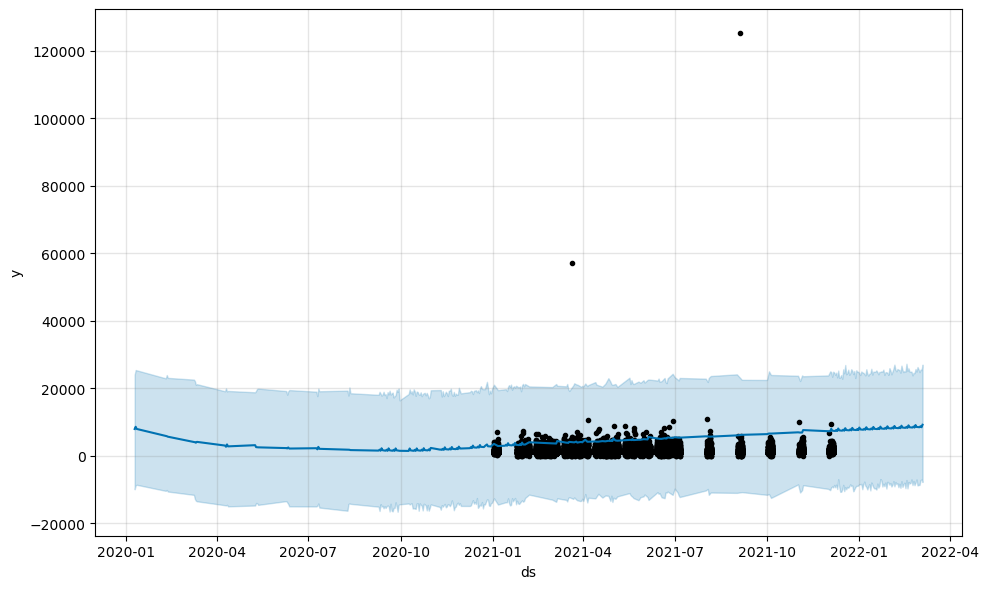

In [154]:
# visualize to make sense of what we are doing

fig1 = m.plot(forecast_2)

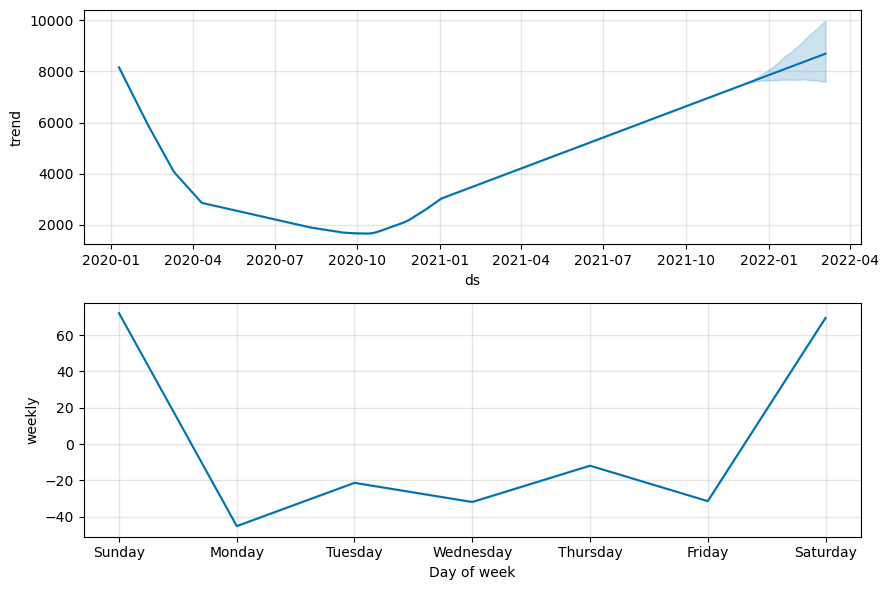

In [191]:
fig2= m.plot_components(forecast_2)